# 5: Loading and Saving Regions

Demonstrate importing / exporting of regions

@author: Guihong Wan and Boshen Yan      
@date: Oct 13, 2023

In [1]:
import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import spatialcells as spc

## Read Anndata and saved region/shapes files

Load epithelial region file from omero csv format and tumor cell region from spatialcell outputs. 

The workflow for generating and saving the tumor cell region can be found at the end of this notebook. 

In [2]:
# Load data
adata = ad.read("../../data/Z147_1_750.h5ad")

In [3]:
# note that you may want to scale the coordinates to convert from pixels to microns
pixels2micron = 0.6
adata.obs.X_centroid = adata.obs.X_centroid*pixels2micron
adata.obs.Y_centroid = adata.obs.Y_centroid*pixels2micron

In [4]:
adata.var_names

Index(['HHLA2', 'CMA1', 'SOX10', 'S100B', 'KERATIN', 'CD1A', 'CD163', 'CD3D',
       'C8A', 'MITF', 'FOXP3', 'PDL1', 'KI67', 'LAG3', 'TIM3', 'PCNA',
       'pSTAT1', 'cPARP', 'SNAIL', 'aSMA', 'HLADPB1', 'S100A', 'CD11C', 'PD1',
       'LDH', 'PANCK', 'CCNA2', 'CCND1', 'CD63', 'CD31'],
      dtype='object')

In [5]:
# The expression is scaled. So, the gate is 0.5
spc.prep.setGate(adata, "SOX10", 0.5)

SOX10_positive
False    586292
True     524293
Name: count, dtype: int64


In [7]:
# Load regions
# note that you may want to scale the coordinates to convert from pixels to microns
epi = spc.utils.importRegion("../data/tutorial5_Z147_1.ome.tif-rois.csv", scale=pixels2micron)

tumor = spc.utils.importRegion("../data/tutorial5_boundary.csv") # see the end of this file for example

In [8]:
# assign cells to regions

adata.obs["tumor_region"] = "non-Tumor"
spc.spatial.assignPointsToRegions(
    adata, [tumor], ["Tumor"], assigncolumn="tumor_region", default="non-Tumor"
)

adata.obs["epi_region"] = "non-Epi"
spc.spatial.assignPointsToRegions(
    adata, [epi], ["Epi"], assigncolumn="epi_region", default="non-Epi"
)

723114it [01:37, 7424.25it/s]


Assigned points to region: Tumor


531709it [00:16, 32188.14it/s]


Assigned points to region: Epi


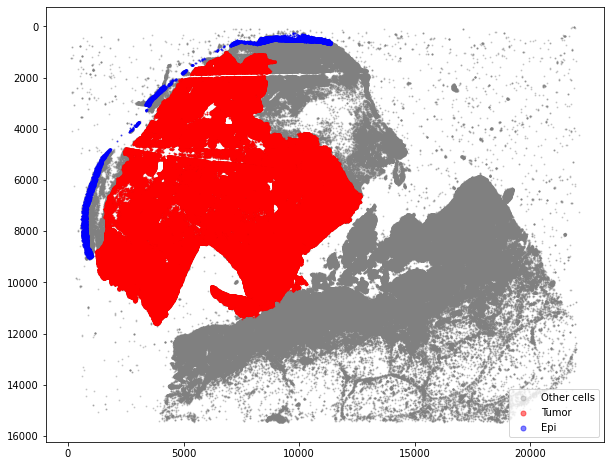

In [9]:
# plot
markersize = 1
fig, ax = plt.subplots(figsize=(10,8))

## all points
ax.scatter(
    *zip(*adata.obs[["X_centroid", "Y_centroid"]].to_numpy()),
    s=markersize, color="grey", alpha=0.3, label="Other cells"
)

## tumor
tumor_tmp = adata.obs[adata.obs["tumor_region"] == "Tumor"]
ax.scatter(
    *zip(*tumor_tmp[["X_centroid", "Y_centroid"]].to_numpy()),
    s=markersize, color="red", alpha=0.5, label="Tumor"
)

## epi
epi_tmp = adata.obs[adata.obs["epi_region"] == "Epi"]
ax.scatter(
    *zip(*epi_tmp[["X_centroid", "Y_centroid"]].to_numpy()),
    s=markersize, color="blue", alpha=0.5, label="Epi"
)
ax.legend(loc="lower right", markerscale=5)
ax.invert_yaxis()
plt.show()

In [10]:
print(adata.obs['epi_region'].value_counts())
print(adata.obs['tumor_region'].value_counts())

epi_region
non-Epi    1098026
Epi          12559
Name: count, dtype: int64
tumor_region
Tumor        586796
non-Tumor    523789
Name: count, dtype: int64


In [11]:
# Calculate distance from tumor boundary
spc.msmt.getDistanceFromObject(
    adata,
    epi,
    region_col="tumor_region",
    region_subset=["Tumor"],
    name="distance_from_epidermis",
    binned=True,
    binsize=1500,
)

586796it [00:10, 56913.73it/s]


In [12]:
print(adata.obs['distance_from_epidermis_binned'].value_counts(sort=False))

distance_from_epidermis_binned
[0, 1500)         92232
[1500, 3000)     122678
[3000, 4500)     120291
[4500, 6000)     102554
[6000, 7500)     105681
[7500, 9000)      43095
[9000, 10500)       265
Name: count, dtype: int64


In [13]:
adata

AnnData object with n_obs × n_vars = 1110585 × 30
    obs: 'X_centroid', 'Y_centroid', 'column_centroid', 'row_centroid', 'Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'Solidity', 'Extent', 'Orientation', 'imageid', 'phenotype', 'kmeans', 'kmeans_renamed', 'pickseq_roi', 'pickseq_roi_minimal', 'dermis_roi', 'epidermis_roi', 'general_roi', 'Kmeans_r', 'der_epider_roi', 'phenotype_proliferation', 'phenograph', 'spatial_expression_phenograph', 'spatial_expression_kmeans', 'phenograph_raw', 'phenograph_raw_minimal', 'phenotype_1', 'phenotype_1_tumor_kmeans', 'phenotype_1_tumor_kmeans_renamed', 'phenotype_final', 'spatial_expression_consolidated', 'MC', 'spatial_count_kmeans', 'phenotype_2', 'phenotype_2_tumor_kmeans', 'phenotype_2_tumor_kmeans_renamed', 'phenotype_large_cohort', 'phenotype_large_cohort_RJP', 'spatial_lda_kmeans', 'phenotype_2_tumor_kmeans_old', 'tumor_expression_trimmed', 'tumor_expression_TC', 'IM_roi', 'TC_ROI_IM_large', 'TC_ROI_IM_small', 'TC_ROI_IM_elar

In [14]:
adata.obs["pheno"] = "Other"
adata.obs.loc[adata.obs["phenotype_proliferation"] == "Proliferating Tumor", "pheno"] = "Proliferating Tumor"
adata.obs.loc[adata.obs["phenotype_proliferation"] == "Proliferating T cells", "pheno"] = "Proliferating T cells"


print(adata.obs['pheno'].value_counts())

pheno
Other                    995691
Proliferating Tumor      100498
Proliferating T cells     14396
Name: count, dtype: int64


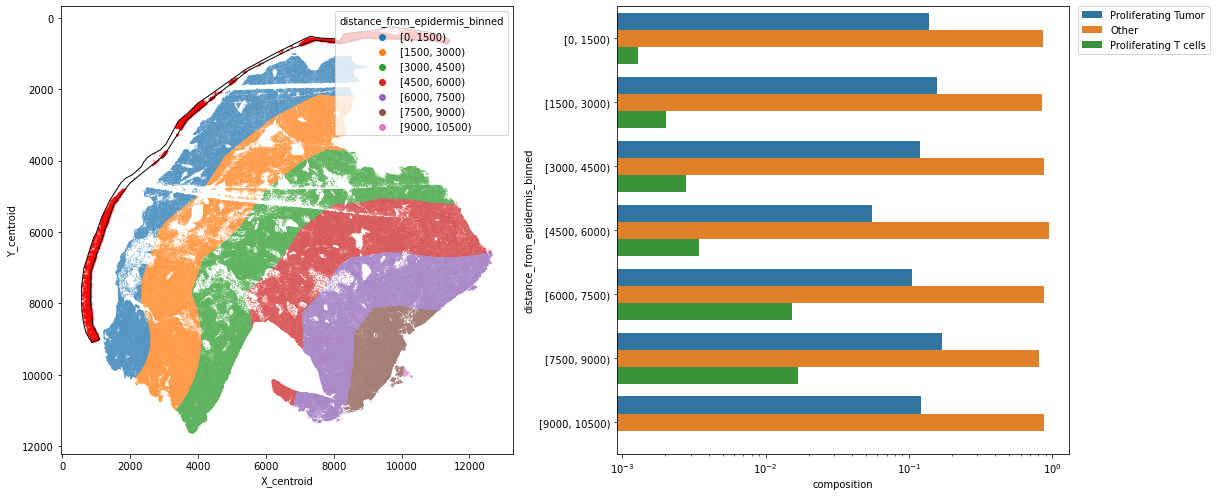

In [15]:
metric_col = "distance_from_epidermis_binned"
pheno = "pheno"


markersize = 0.5
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(17, 7))

## Plot epidermis points and boundary
epi_tmp = adata.obs[adata.obs["epi_region"] == "Epi"]
ax1.scatter(
    *zip(*epi_tmp[["X_centroid", "Y_centroid"]].to_numpy()),
    s=markersize, color="red", alpha=0.5
)
spc.plt.plotBoundary(epi, ax=ax1, linewidth=1.0, color="k")


## Plot tumor points by distance from epidermis
sns.scatterplot(
    data=adata.obs,
    x="X_centroid",
    y="Y_centroid",
    hue=metric_col,
    alpha=0.8,
    s=markersize,
    ax=ax1,
)
ax1.invert_yaxis()
ax1.legend(loc="upper right", title=metric_col)


## Plot region composition barplots
df = spc.msmt.getRegionComposition(
    adata, 
    [metric_col, pheno], 
    regions=["Tumor"], 
    regioncol="tumor_region"
).sort_values(by=metric_col, ascending=False)

sns.barplot(data=df, y=metric_col, x="composition", hue=pheno, log=True, ax=ax2)
ax2.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.tight_layout()
plt.show()

## Generate and export tumor region

The following steps compute the tumor cell region based on SOX10+ cells for distance measurement with the epithelial cells. For detailed tutorial, please refer to tutorial 0. 

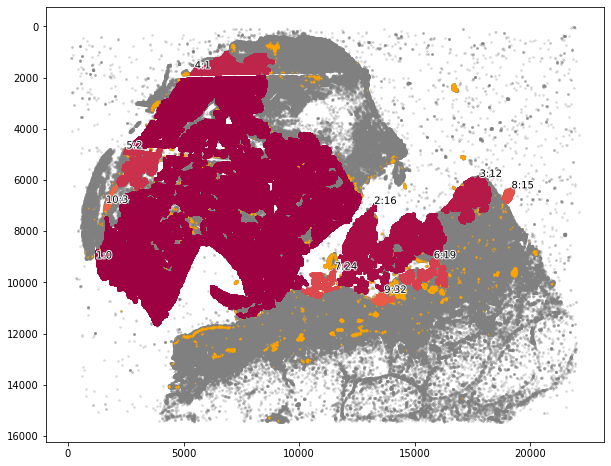

In [58]:
markers_of_interest = ["SOX10_positive"]
communitycolumn = "SOX10_community"

ret = spc.spa.getCommunities(
    adata,
    markers_of_interest,
    eps=90,  # smaller --> more cells are considered as outliers.
    newcolumn=communitycolumn,
)

fig, ax = plt.subplots(figsize=(10, 8))
spc.plt.plotCommunities(
    adata, ret, communitycolumn, plot_first_n_clusters=10, s=1, fontsize=10, ax=ax
)
ax.invert_yaxis()
plt.show()

In [60]:
clusters_idx_sorted = [idx for npoints, idx in ret[0]]
plot_first_n_clusters = 10
print(
    "Indexes of the",
    plot_first_n_clusters,
    "largest clusters:\n",
    clusters_idx_sorted[:plot_first_n_clusters],
)
print("Cluster size and index:\n", ret[0][:plot_first_n_clusters])



Indexes of the 10 largest clusters:
 [0, 16, 12, 1, 2, 19, 24, 15, 32, 3]
Cluster size and index:
 [(420503, 0), (53646, 16), (13179, 12), (9583, 1), (8328, 2), (6697, 19), (3407, 24), (1586, 15), (995, 32), (557, 3)]


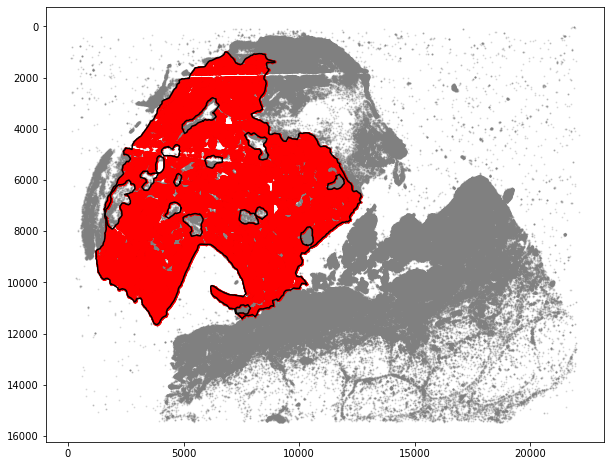

In [62]:
# Here we choose the three largest ones of interest in the larger tumor region:
communityIndexList = [0, 1, 2, 3]

boundary = spc.spa.getBoundary(adata, communitycolumn, communityIndexList, alpha=100)
# filter out small regions or holes based on the number of edges
# or the area of the region
boundary_pruned = spc.spa.pruneSmallComponents(
    boundary, min_edges=50, holes_min_edges=50, holes_min_area=50000
)

markersize = 1
fig, ax = plt.subplots(figsize=(10, 8))
## all points
ax.scatter(
    *zip(*adata.obs[["X_centroid", "Y_centroid"]].to_numpy()),
    s=markersize, color="grey", alpha=0.2
)

# Points in selected commnities
xy = adata.obs[adata.obs[communitycolumn].isin(communityIndexList)][
    ["X_centroid", "Y_centroid"]
].to_numpy()
ax.scatter(xy[:, 0], xy[:, 1], s=markersize, color="r")

# Boundary of selected communities
spc.plt.plotBoundary(boundary_pruned, ax=ax)
ax.invert_yaxis()
plt.show()

## Save the boundary objects generated 
Boundary objects can be saved as geojson type files or omero format csv files. Note that currently, saving to csv format ignores the holes inside boundary regions. To preserve information of the holes, save to a json/geojson file instead. 

In [5]:
spc.utils.exportRegion(boundary_pruned, "../data/tutorial5_boundary.json")
spc.utils.exportRegion(boundary_pruned, "../data/tutorial5_boundary.csv")

'{"type":"MultiPolygon","coordinates":[[[[7377.602943319256,11265.546483982396],[7377.687364890276,11265.647648543443],[7398.785844577061,11287.78593094544],[7398.893507692692,11287.883587612476],[7427.174899640779,11310.012875187302],[7427.212336858052,11310.040784298144],[7441.717413094196,11320.336190500699],[7532.018077308936,11421.638825962767],[7532.088179621043,11421.709973009738],[7532.165029633437,11421.77377200699],[7532.2478606722225,11421.829586480644],[7532.335846395371,11421.87685961231],[7532.428109036503,11421.91511979405],[7532.523728161695,11421.943985333244],[7532.621749851944,11421.963168260447],[7532.721196219691,11421.972477202242],[7532.8210751644565,11421.971819290424],[7532.92039027027,11421.961201088478],[7533.018150746154,11421.940728526095],[7533.1133813104825,11421.9106058424],[7533.20513192063,11421.871133548408],[7533.292487250815,11421.822705429058],[7533.3745758236055,11421.765804614719],[7533.450578703992,11421.700998761367],[7533.519737669266,11421.62